In [1]:
import uproot, ROOT, glob, os, random
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 16.0 # Use 14 point font
sns.set(style="whitegrid")

path = '/eos/user/j/jlai/ditau/'

branches = ['ditau_pt', 'n_subjets', 'IsTruthHadronic', 'n_tracks_lead', 'n_tracks_subl',
 'R_max_lead', 'R_max_subl', 'R_tracks_subl', 'R_isotrack', 'd0_leadtrack_lead',
 'd0_leadtrack_subl', 'f_core_lead', 'f_core_subl', 'f_subjet_subl', 'f_subjets',
 'f_isotracks', 'm_core_lead', 'm_core_subl', 'm_tracks_lead', 'm_tracks_subl',
 'n_track']

training_vars = [
    "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
    "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl", "m_core_lead",
    "m_core_subl", "m_tracks_lead", "m_tracks_subl", "d0_leadtrack_lead",
    "d0_leadtrack_subl", "n_track", "n_tracks_lead"
]

Welcome to JupyROOT 6.30/04


## Read data (h5 -> panda)

In [3]:
%%time

signal = pd.read_csv('combined_signal_inc_3.csv')
bkg = pd.read_csv('combined_bkg_inc_3.csv')

signal['label'] = 1
bkg['label'] = 0
signal['weight'] = signal['event_weight'] * signal['pT_weight']
bkg['weight'] = bkg['event_weight'] * bkg['pT_weight']

df = pd.concat((bkg, signal))
df = df[4:] # get rid of jz0 and jz1
df = df[df.f_core_subl != -999]
df.describe()

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_track,n_tracks_lead,n_tracks_subl,n_subjets,event_weight,bdt_score,bdt_score_new,eta,average_mu,pT_weight
4,28661182,207010.69,0,0.883104,0.701180,0.167451,0.676483,0.022352,0.041758,0.114734,...,7,3,3,3,1.601067e-01,0.437940,0.165671,0.418528,41.499996,4.301412e-03
5,31012373,202973.78,0,0.893525,0.713387,0.213471,0.608883,0.013195,0.046999,0.161529,...,7,3,3,3,2.489046e-02,0.509698,0.451603,-0.050249,56.499996,4.301412e-03
6,26917460,221883.73,0,0.882286,0.677054,0.317602,0.644228,0.009284,0.103811,0.168752,...,5,3,1,3,5.294116e-03,0.561275,0.070575,2.297925,42.500000,4.747170e-03
7,31183017,223984.75,0,0.841569,0.756340,0.274110,0.674390,0.023144,0.047328,0.143165,...,9,3,3,4,9.956257e-02,0.461499,0.092040,-1.814815,64.500000,4.747170e-03
8,32682502,211992.60,0,0.749230,0.562946,0.325747,0.695295,0.012508,0.160978,0.177324,...,3,1,1,3,4.558297e-03,0.521241,0.048879,0.286800,28.500000,4.301412e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842177,9237189,438753.22,1,0.879513,0.500879,0.062951,0.874868,0.008182,0.008770,0.055838,...,2,1,1,2,2.687196e-14,0.694107,0.769784,-0.021523,65.500000,9.965570e+07
4842178,9237200,536151.50,1,0.963188,0.968734,0.418105,0.916234,0.000000,0.003844,0.016558,...,2,1,1,2,1.932851e-15,0.804363,0.997562,0.052506,67.500000,3.131079e+08
4842179,9237190,307591.25,1,0.958650,0.765725,0.144097,0.840550,0.003121,0.006494,0.037982,...,4,1,3,2,2.933390e-13,0.737839,0.995496,-0.187987,66.500000,2.217758e+07
4842180,9237198,657908.60,1,0.970700,0.658217,0.297966,0.911666,0.004199,0.003290,0.074464,...,4,1,3,2,5.657686e-15,0.705296,0.927411,-0.484089,67.500000,1.087874e+09


## pT w/ evt weight

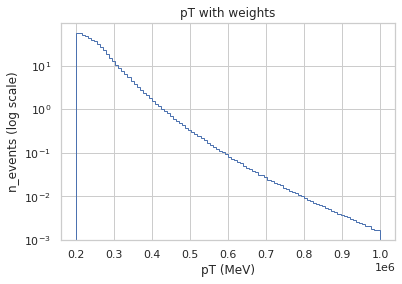

In [12]:
plt.hist(df['ditau_pt'], bins=100, weights=df['event_weight'], histtype='step')
plt.yscale('log')
plt.xlabel('pT (MeV)')
plt.ylabel('n_events (log scale)')
plt.title('pT with weights')
plt.show()

## Training vars plot w/ (evt weight*pT weight)
### separated by 1p1p, 1p3p, 3p3p

In [17]:
df_1p1p = df[(df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 1)]
df_3p3p = df[(df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 3)]
df_1p3p = df[
    ((df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 3)) |
    ((df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 1))
]

len(df_1p1p), len(df_3p3p), len(df_1p3p)

(3010333, 942445, 3069959)

17it [00:19,  1.13s/it]


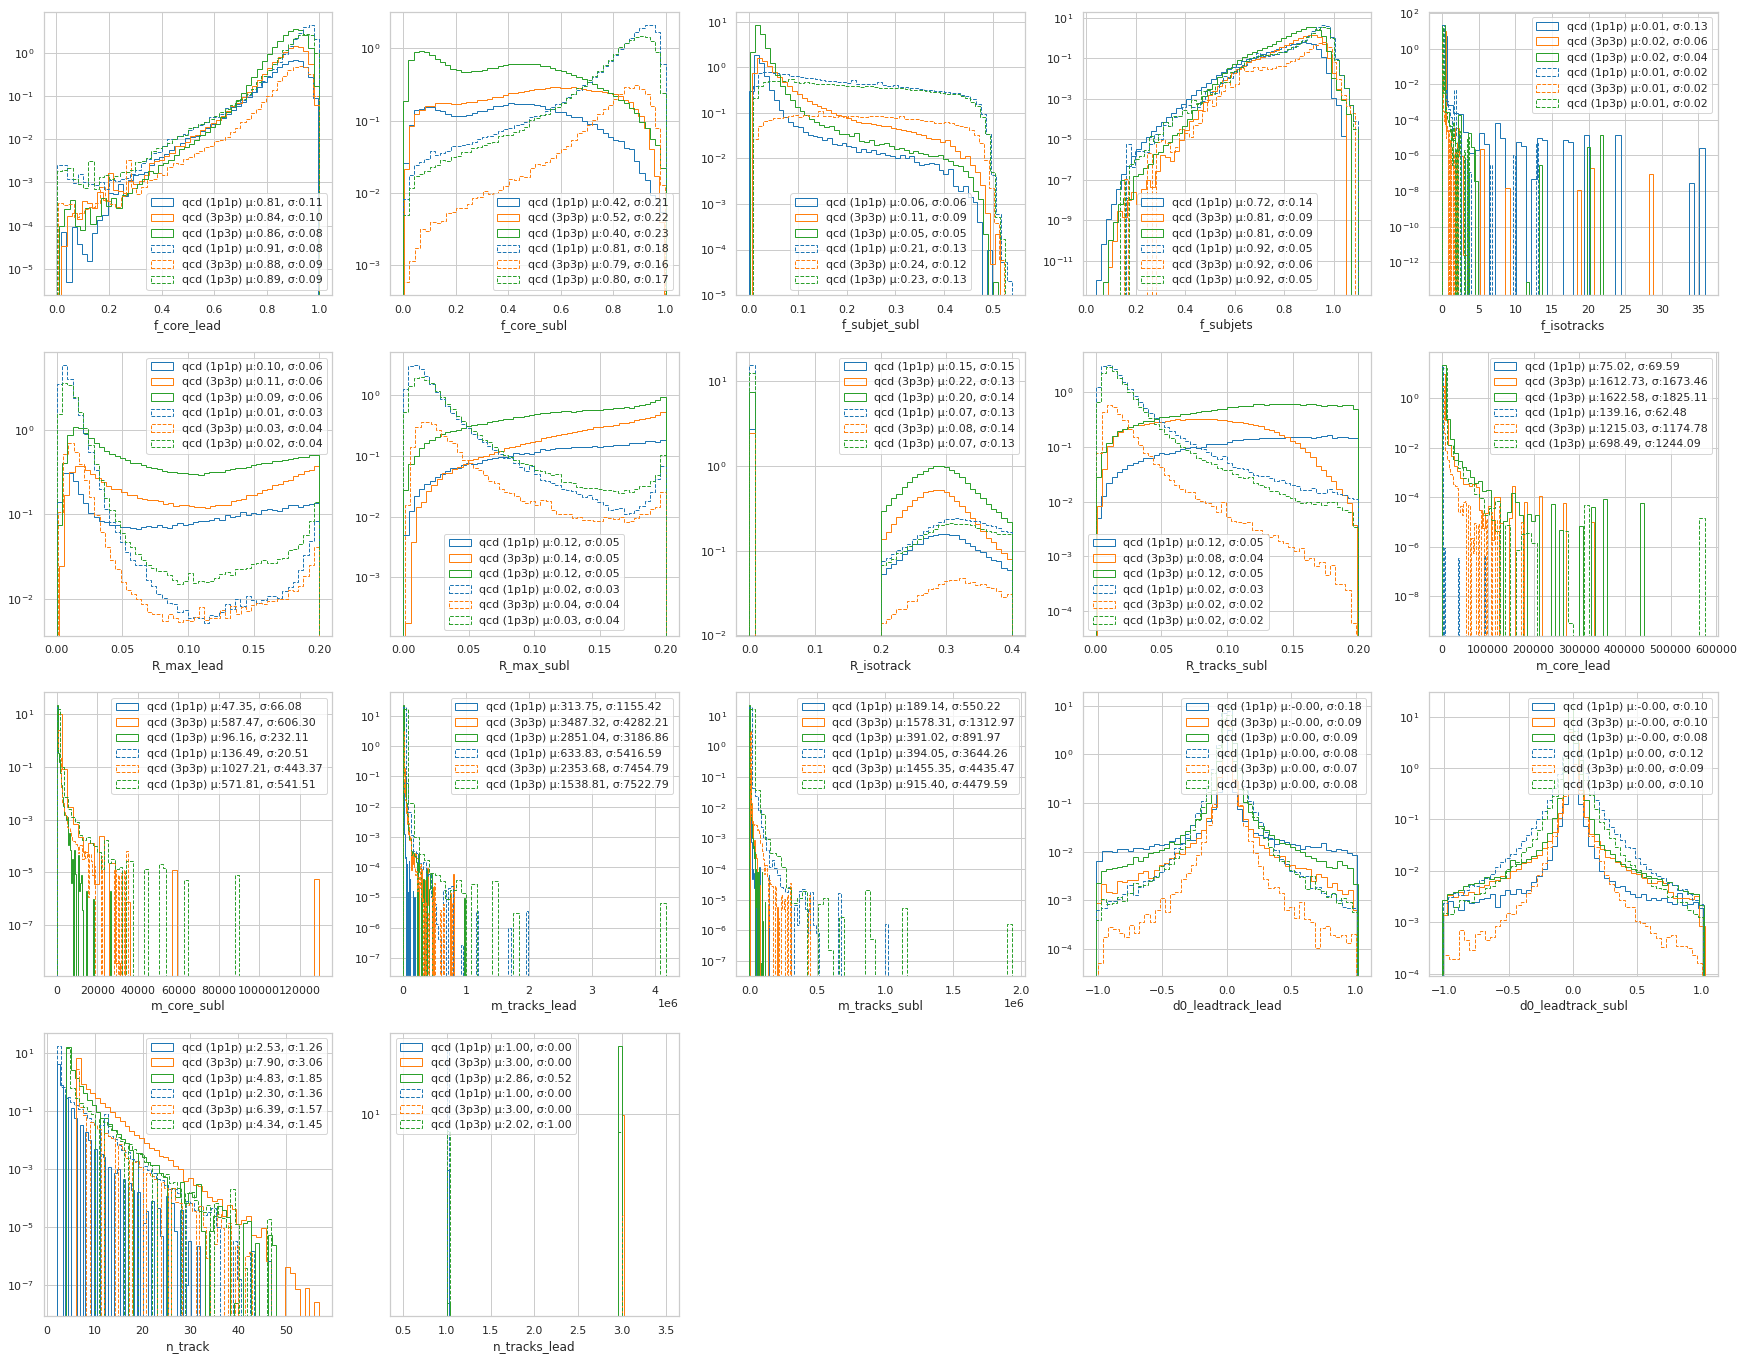

In [18]:
%%time
cmap = plt.get_cmap("tab10")
plt.figure(figsize=(30, 24))
def hist(variable, plot_num):

    plt.subplot(4, 5, plot_num)
    bin = 50
    bkg = df_1p1p[df_1p1p.label==0]
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, color=cmap(0), weights=bkg['weight'], label=f'qcd (1p1p) μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    bkg = df_3p3p[df_3p3p.label==0]
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, color=cmap(1), weights=bkg['weight'], label=f'qcd (3p3p) μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    bkg = df_1p3p[df_1p3p.label==0]
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, color=cmap(2), weights=bkg['weight'], label=f'qcd (1p3p) μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')

    signal = df_1p1p[df_1p1p.label==1]
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, color=cmap(0), linestyle='--', weights=signal['weight'], label=f'qcd (1p1p) µ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    signal = df_3p3p[df_3p3p.label==1]
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, color=cmap(1), linestyle='--', weights=signal['weight'], label=f'qcd (3p3p) μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    signal = df_1p3p[df_1p3p.label==1]
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, color=cmap(2), linestyle='--', weights=signal['weight'], label=f'qcd (1p3p) μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')

    plt.xlabel(variable)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

for i, label in tqdm(enumerate(training_vars, 1)):
    hist(label, i)

17it [00:20,  1.18s/it]


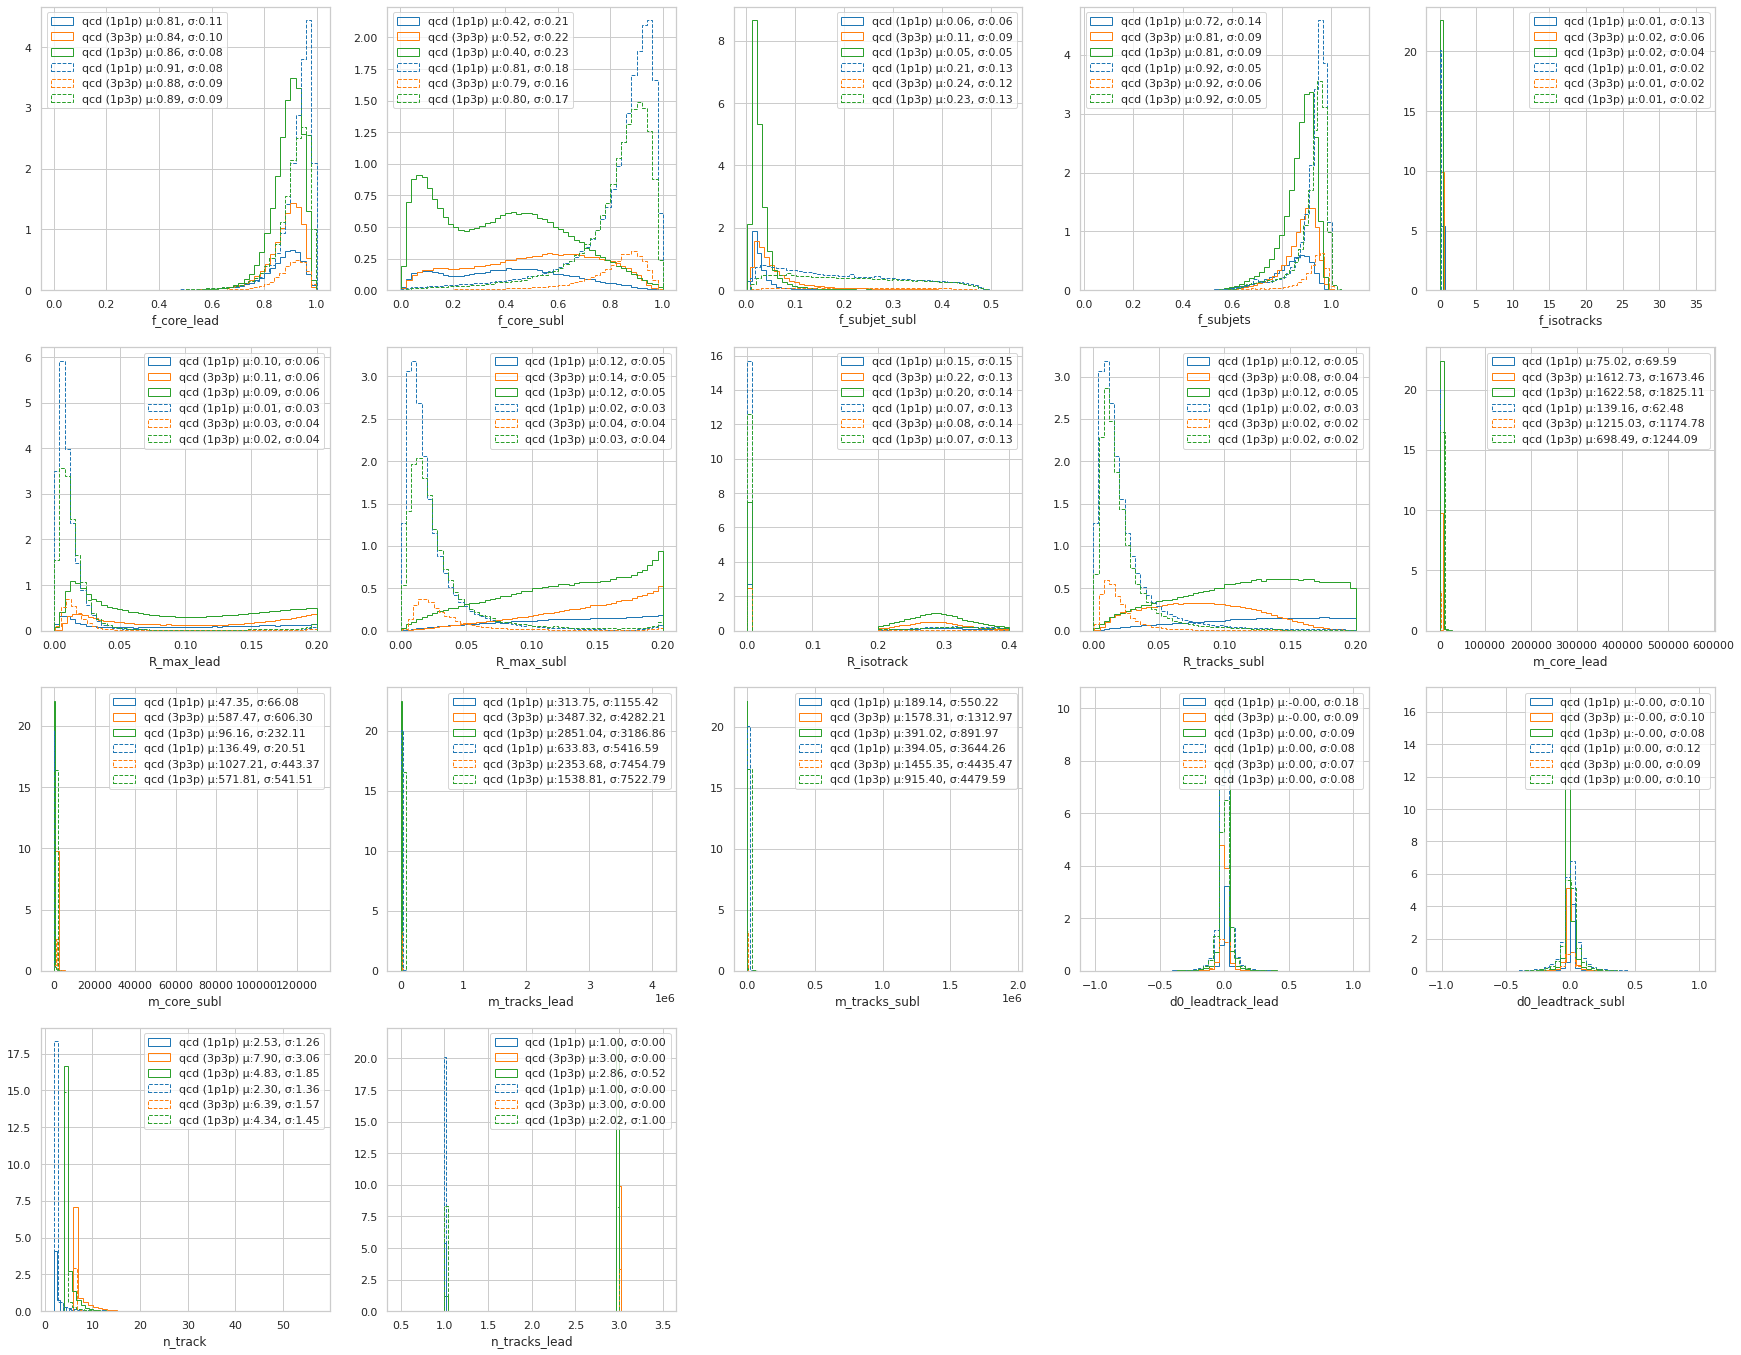

In [19]:
cmap = plt.get_cmap("tab10")
plt.figure(figsize=(30, 24))
def hist(variable, plot_num):

    plt.subplot(4, 5, plot_num)
    bin = 50
    bkg = df_1p1p[df_1p1p.label==0]
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, color=cmap(0), weights=bkg['weight'], label=f'qcd (1p1p) μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    bkg = df_3p3p[df_3p3p.label==0]
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, color=cmap(1), weights=bkg['weight'], label=f'qcd (3p3p) μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    bkg = df_1p3p[df_1p3p.label==0]
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, color=cmap(2), weights=bkg['weight'], label=f'qcd (1p3p) μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')

    signal = df_1p1p[df_1p1p.label==1]
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, color=cmap(0), linestyle='--', weights=signal['weight'], label=f'qcd (1p1p) µ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    signal = df_3p3p[df_3p3p.label==1]
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, color=cmap(1), linestyle='--', weights=signal['weight'], label=f'qcd (3p3p) μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    signal = df_1p3p[df_1p3p.label==1]
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, color=cmap(2), linestyle='--', weights=signal['weight'], label=f'qcd (1p3p) μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')

    plt.xlabel(variable)
    #plt.yscale('log')
    plt.legend()
    plt.grid(True)

for i, label in tqdm(enumerate(training_vars, 1)):
    hist(label, i)

7it [00:07,  1.10s/it]


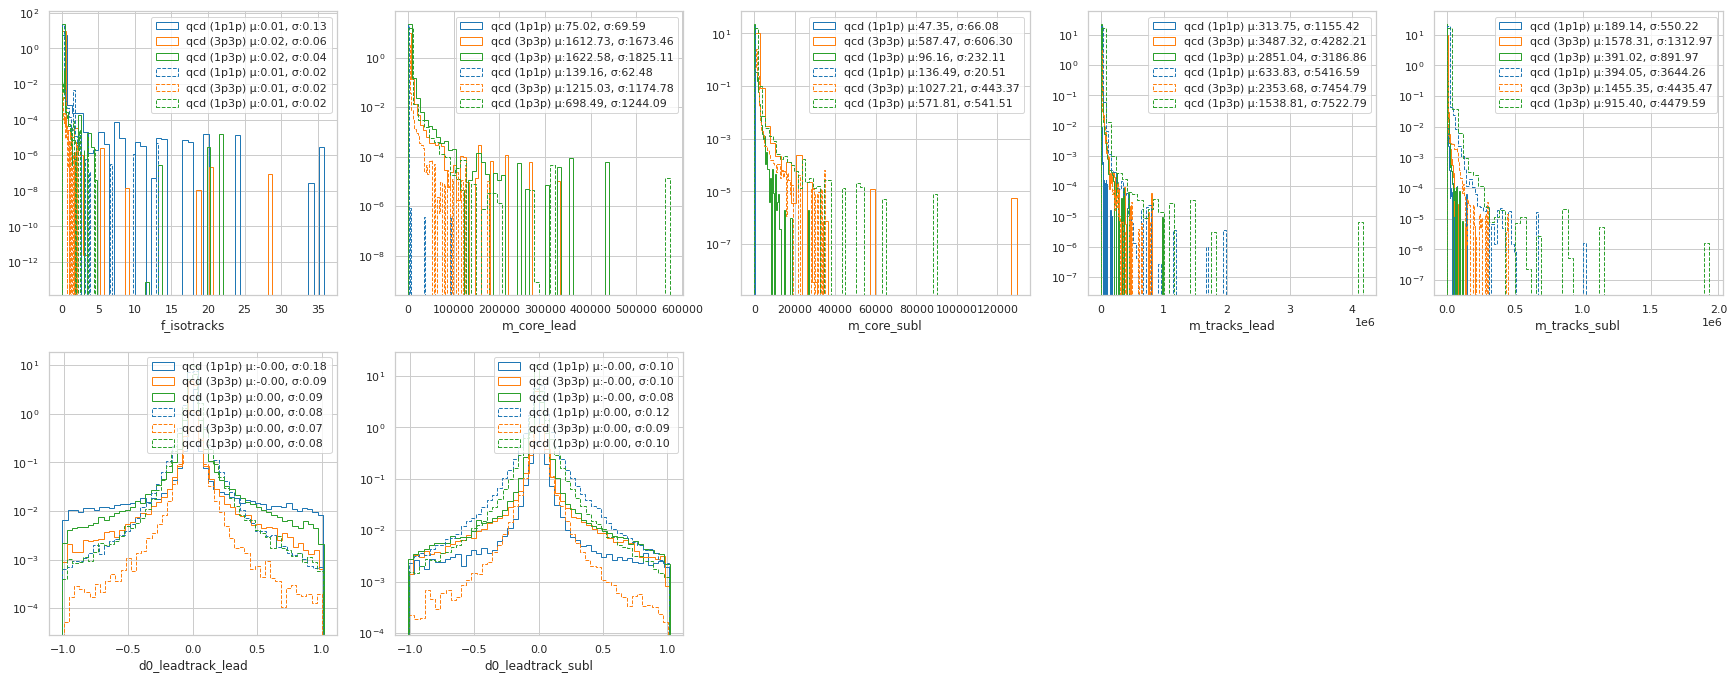

In [20]:
log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl", "d0_leadtrack_lead", "d0_leadtrack_subl"]

cmap = plt.get_cmap("tab10")
plt.figure(figsize=(30, 24))
def hist(variable, plot_num):

    plt.subplot(4, 5, plot_num)
    bin = 50
    bkg = df_1p1p[df_1p1p.label==0]
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, color=cmap(0), weights=bkg['weight'], label=f'qcd (1p1p) μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    bkg = df_3p3p[df_3p3p.label==0]
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, color=cmap(1), weights=bkg['weight'], label=f'qcd (3p3p) μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    bkg = df_1p3p[df_1p3p.label==0]
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, color=cmap(2), weights=bkg['weight'], label=f'qcd (1p3p) μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')

    signal = df_1p1p[df_1p1p.label==1]
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, color=cmap(0), linestyle='--', weights=signal['weight'], label=f'qcd (1p1p) µ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    signal = df_3p3p[df_3p3p.label==1]
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, color=cmap(1), linestyle='--', weights=signal['weight'], label=f'qcd (3p3p) μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    signal = df_1p3p[df_1p3p.label==1]
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, color=cmap(2), linestyle='--', weights=signal['weight'], label=f'qcd (1p3p) μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')

    plt.xlabel(variable)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

for i, label in tqdm(enumerate(log_vars, 1)):
    hist(label, i)

### w/out separation

17it [00:04,  3.69it/s]


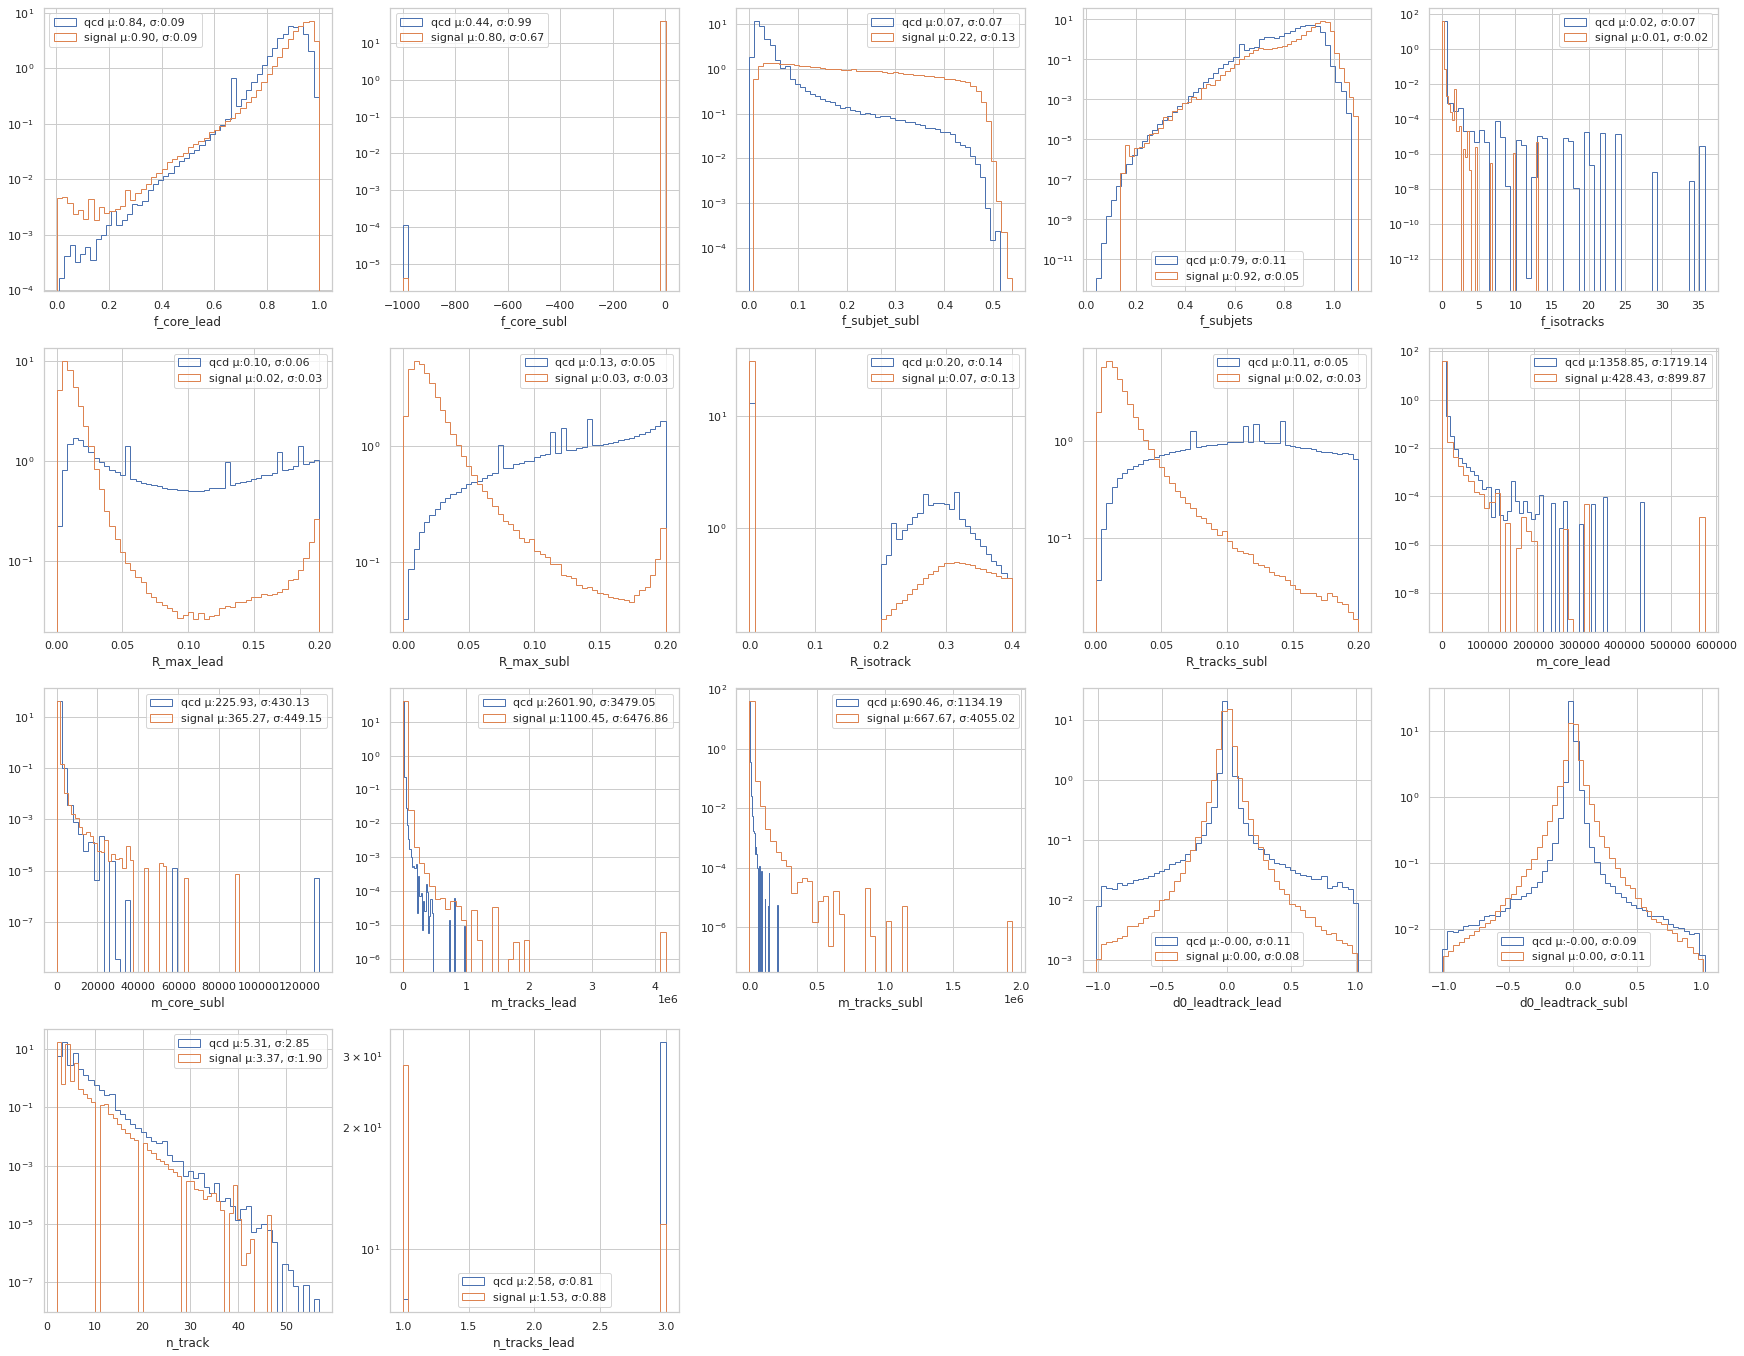

In [22]:
plt.figure(figsize=(30, 24))
def hist(variable, plot_num):
    plt.subplot(4, 5, plot_num)
    bin = 50
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, weights=bkg['weight'], label=f'qcd μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, weights=signal['weight'], label=f'signal μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    plt.xlabel(variable)
    #plt.ylabel("Number of Events (scaled)")
    #plt.title(xlabel)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

for i, label in tqdm(enumerate(training_vars, 1)):
    hist(label, i)

7it [00:02,  3.45it/s]


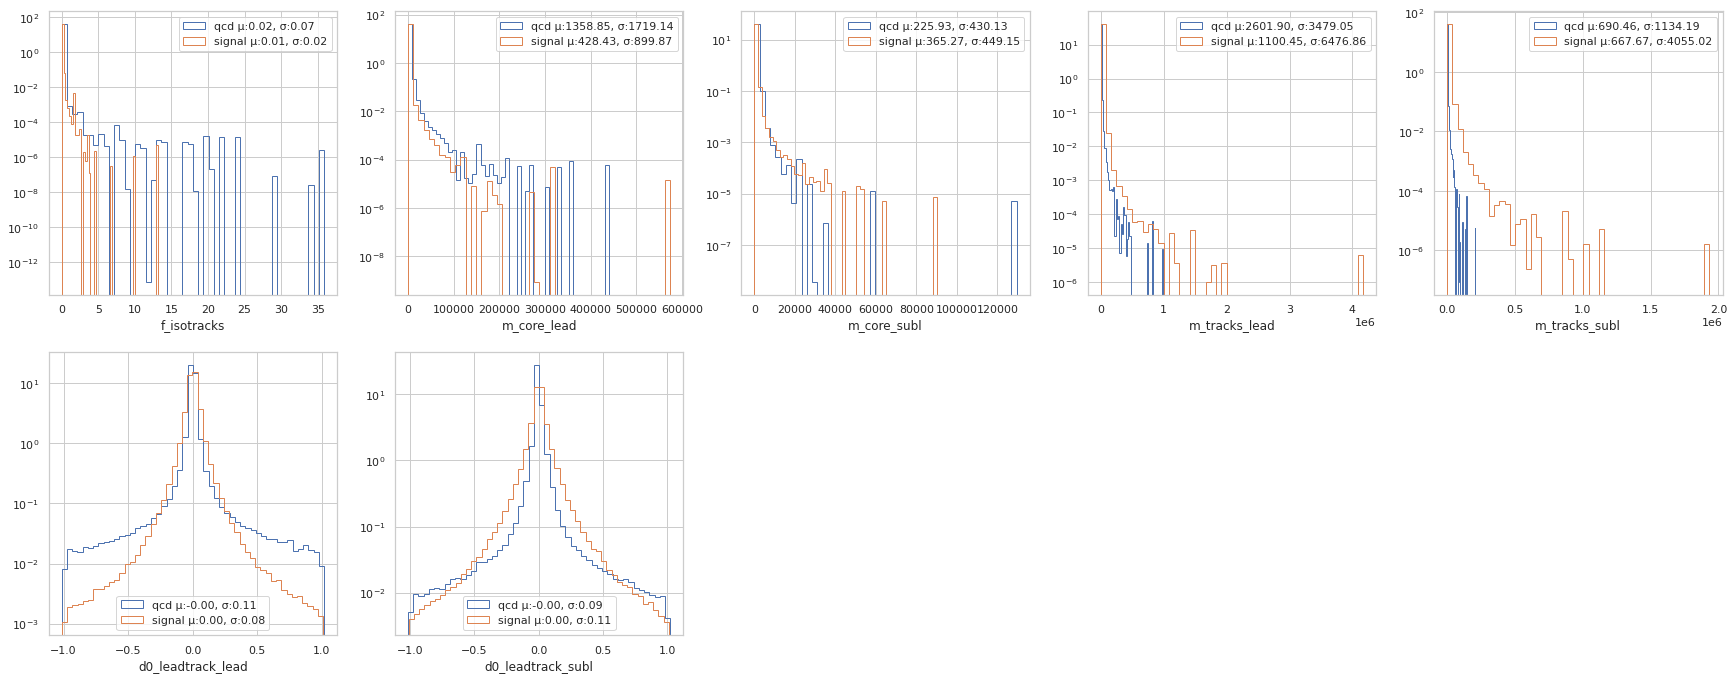

In [21]:
plt.figure(figsize=(30, 24))
def hist(variable, plot_num):
    plt.subplot(4, 5, plot_num)
    bin = 50
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, weights=bkg['weight'], label=f'qcd μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, weights=signal['weight'], label=f'signal μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    plt.xlabel(variable)
    #plt.ylabel("Number of Events (scaled)")
    #plt.title(xlabel)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

for i, label in tqdm(enumerate(log_vars, 1)):
    hist(label, i)

## Percentage for log_vars == 0

In [23]:
# All
filtered_counts = {var: f"{df[df[var] == 0].shape[0]/len(df)*100:.3f}%" for var in log_vars}

filtered_counts

{'f_isotracks': '26.390%',
 'm_core_lead': '3.014%',
 'm_core_subl': '15.297%',
 'm_tracks_lead': '0.000%',
 'm_tracks_subl': '0.000%',
 'd0_leadtrack_lead': '3.014%',
 'd0_leadtrack_subl': '15.297%'}

In [25]:
# bkg
filtered_counts = {var: f"{bkg[bkg[var] == 0].shape[0]/len(bkg)*100:.3f}%" for var in log_vars}

filtered_counts

{'f_isotracks': '8.341%',
 'm_core_lead': '9.088%',
 'm_core_subl': '45.345%',
 'm_tracks_lead': '0.000%',
 'm_tracks_subl': '0.000%',
 'd0_leadtrack_lead': '9.088%',
 'd0_leadtrack_subl': '45.345%'}

In [24]:
# signal
filtered_counts = {var: f"{signal[signal[var] == 0].shape[0]/len(signal)*100:.3f}%" for var in log_vars}

filtered_counts

{'f_isotracks': '34.519%',
 'm_core_lead': '0.278%',
 'm_core_subl': '1.765%',
 'm_tracks_lead': '0.000%',
 'm_tracks_subl': '0.000%',
 'd0_leadtrack_lead': '0.278%',
 'd0_leadtrack_subl': '1.765%'}